In [1]:
!pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install -q --upgrade requests==2.32.3 bitsandbytes==0.46.0 transformers==4.48.3 accelerate==1.3.0 datasets==3.2.0 peft==0.14.0 trl==0.14.0 matplotlib wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login

import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from datasets import load_dataset
from peft import PeftModel
import matplotlib.pyplot as plt

# === Constants ===
BASE_MODEL = "tiiuae/falcon-7b-instruct"
PROJECT_NAME = "pricer"
HF_USER = "fakharbutt44"  # Change to your HF username
RUN_NAME = "2025-08-05_07.12.59"  # Update to the run name of your training
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

DATASET_NAME = "ed-donner/pricer-data"

#DATASET_NAME = f"{HF_USER}/pricer-data"
QUANT_4_BIT = True

# Colors for printing
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red": RED, "orange": YELLOW, "green": GREEN}

%matplotlib inline


In [3]:
# Hugging Face login
hf_token = userdata.get('p')
login(hf_token, add_to_git_credential=True)

# Load dataset
dataset = load_dataset(DATASET_NAME)
test = dataset['test']
print(test[0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/416 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/914k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'text': "How much does this cost to the nearest dollar?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K\n\nPrice is $", 'price': 374.41}


In [4]:
# Quantization config
if QUANT_4_BIT:
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4"
    )
else:
    quant_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_compute_dtype=torch.bfloat16
    )

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
    trust_remote_code=True
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

# Load fine-tuned LoRA model
fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)

print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_falcon.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- configuration_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.



modeling_falcon.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/771 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

Memory footprint: 4165.6 MB


In [5]:
def extract_price(s):
    if "Price is $" in s:
        contents = s.split("Price is $")[1]
        contents = contents.replace(',', '')
        match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
        return float(match.group()) if match else 0
    return 0


In [6]:
# Greedy prediction
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = fine_tuned_model.generate(inputs, attention_mask=attention_mask, max_new_tokens=3)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

# Weighted top-k prediction
top_K = 3
def improved_model_predict(prompt, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)

    prices, weights = [], []
    for i in range(top_K):
        predicted_token = tokenizer.decode(top_token_id[0][i])
        probability = top_prob[0][i]
        try:
            result = float(predicted_token)
        except ValueError:
            result = 0.0
        if result > 0:
            prices.append(result)
            weights.append(probability)

    if not prices:
        return 0.0, 0.0

    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
    return sum(weighted_prices).item()


In [7]:
class Tester:
    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses, self.truths, self.errors, self.sles, self.colors = [], [], [], [], []

    def color_for(self, error, truth):
        if error < 40 or error / truth < 0.2:
            return "green"
        elif error < 80 or error / truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth + 1) - math.log(guess + 1)
        sle = log_error ** 2
        color = self.color_for(error, truth)

        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)

        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f}{RESET}")

    def chart(self, title):
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color == "green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()


1: Guess: $173.50 Truth: $374.41 Error: $200.91 SLE: 0.59
2: Guess: $128.75 Truth: $225.11 Error: $96.36 SLE: 0.31
3: Guess: $53.56 Truth: $61.68 Error: $8.12 SLE: 0.02
4: Guess: $327.00 Truth: $599.99 Error: $272.99 SLE: 0.37
5: Guess: $78.81 Truth: $16.99 Error: $61.82 SLE: 2.22
6: Guess: $12.31 Truth: $31.99 Error: $19.68 SLE: 0.82
7: Guess: $125.38 Truth: $101.79 Error: $23.58 SLE: 0.04
8: Guess: $250.75 Truth: $289.00 Error: $38.25 SLE: 0.02
9: Guess: $267.50 Truth: $635.86 Error: $368.36 SLE: 0.75
10: Guess: $48.94 Truth: $65.99 Error: $17.05 SLE: 0.09
11: Guess: $241.88 Truth: $254.21 Error: $12.34 SLE: 0.00
12: Guess: $178.62 Truth: $412.99 Error: $234.37 SLE: 0.70
13: Guess: $102.88 Truth: $205.50 Error: $102.62 SLE: 0.47
14: Guess: $108.12 Truth: $248.23 Error: $140.10 SLE: 0.68
15: Guess: $292.75 Truth: $399.00 Error: $106.25 SLE: 0.10
16: Guess: $157.25 Truth: $373.94 Error: $216.69 SLE: 0.74
17: Guess: $96.75 Truth: $92.89 Error: $3.86 SLE: 0.00
18: Guess: $78.62 Truth: $5

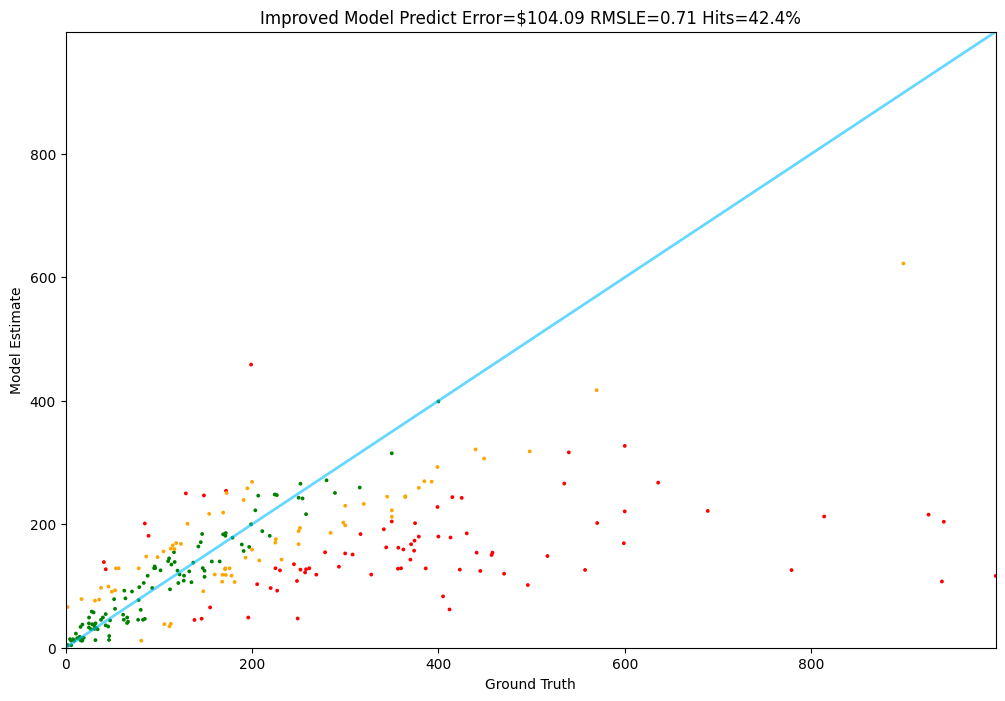

In [8]:
Tester.test(improved_model_predict, test)
